# Quick Draw Neural Network

The [Quick Draw Dataset](https://quickdraw.withgoogle.com/data) is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.

In this notebook I attempt to create a Deep Learning Neural Network to classify the drawings.

After building the model I will build a web applicationt to implement this into [safoan.me](https://www.safoan.me)

## Data Processing
For this project I will make use of the `.npy` Numpy Bitmaps which on top of the simplification:
1. Align the drawing to the top-left corner, to have minimum values of 0.
2. Uniformly scale the drawing, to have a maximum value of 255.
3. Resample all strokes with a 1 pixel spacing.
4. Simplify all strokes using the Ramer–Douglas–Peucker algorithm with an epsilon value of 2.0.

Have also been redered in 28x28 gray scale images into numpy `.npy` format, while also being re-aligned to the center of the drawing bounding box. Due to this being pre-processed it makes it easier to work with.

**Metric** used will be **Accuracy** as the primary goal is to correctly guess as many as possible.

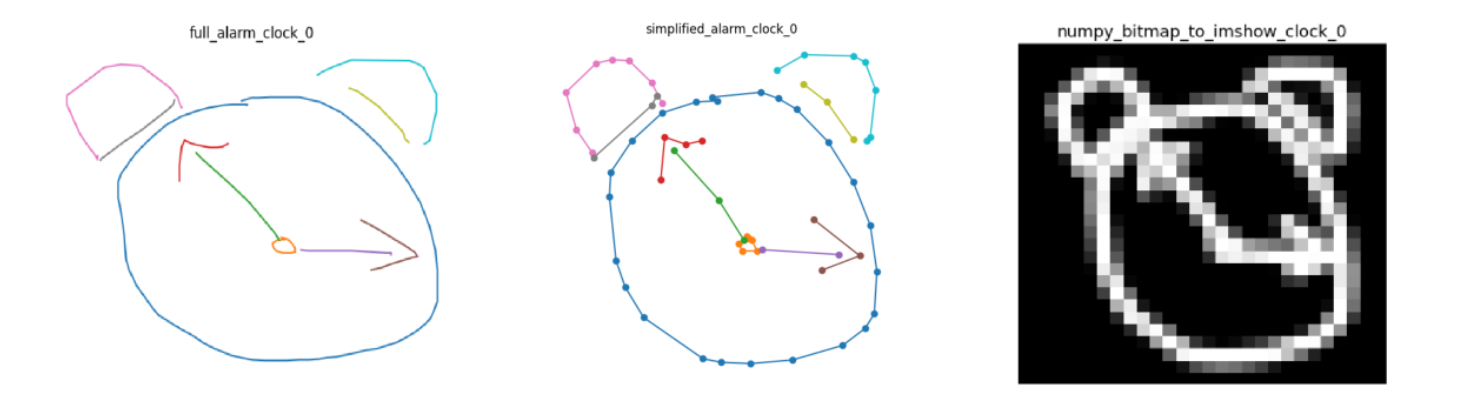

**Install the numpy bitmap "images"**
```bash
    mkdir numpy_bitmap
    gsutil -m cp "gs://quickdraw_dataset/full/numpy_bitmap/*.npy" numpy_bitmap
```

In [1]:
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from scipy.ndimage import rotate

import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

For I notice the file names arent standardised, some with capitals, some with spaces so ill begin with that.

Then for runtimes for now I'll only work with 10 categories, as opposed to the total 345. This reduces the data from 50,000,000+ bitmaps.

In [2]:
IMAGES_DIR = "numpy_bitmap/"

# standardize filenames
# for filename in os.listdir(IMAGES_DIR):
#     os.rename(IMAGES_DIR + filename, IMAGES_DIR + filename.replace(" ", "_").lower())

cat_a = os.listdir(IMAGES_DIR)
print(f'Total categories: {len(cat_a)}')

cat_s = cat_a[12:22]
print(f'Sample categories: {cat_s}')

Total categories: 345
Sample categories: ['dog.npy', 'axe.npy', 'bat.npy', 'alarm_clock.npy', 'backpack.npy', 'blueberry.npy', 'elephant.npy', 'broom.npy', 'cruise_ship.npy', 'beard.npy']


In [3]:
# add all drawings into a dataframe
bmap_split = pd.DataFrame()
bmap = pd.DataFrame()
bitmaps = []

for category in cat_s:
    data = pd.DataFrame(np.load(IMAGES_DIR + category))
    data["category"] = category
    bitmaps.append(data)
    
bmap_split = pd.concat(bitmaps, ignore_index=True)
bmap_split.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,category
932162,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,broom.npy
722322,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,blueberry.npy
279045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bat.npy
1278825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,beard.npy
288743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bat.npy


In [4]:
bmap["y"] = bmap_split["category"].apply(lambda x: x.split(".")[0])
bmap["X"] = bmap_split.iloc[:, :-1].apply(lambda x: np.array(x).reshape(28,28), axis=1)

### Visualizations
Using `matplotlib`

In [5]:
def show_images(df, n_images, category=None):
    
    '''
    Converting n_images of bitmap arrays into images
    
    parameters:
    df: dataframe with X and y columns, 
        X: bitmap array
        y: category label
    n_images: number of images to display
    
    output: figure with n_images labelled
    return: none
    '''
    fig_h = 1.5 * (n_images//10) # height of the figure
    fig, axs = plt.subplots(n_images//10, 10, figsize=(12, fig_h))
    axs = axs.flatten() # 2D - 1D to make it simpler to iterate trough, eg: ax[0,0] -> ax[0]
    
    if not category:
        sample = df.sample(n_images)
    else:
        sample = df[df['y'] == category].sample(n_images)
    
    label = sample['y'].values
    image = sample['X'].values
    
    for n in range(n_images):
        axs[n].imshow(image[n])
        axs[n].set_title(label[n])
        axs[n].axis('off')
    
    plt.tight_layout()
    plt.show()

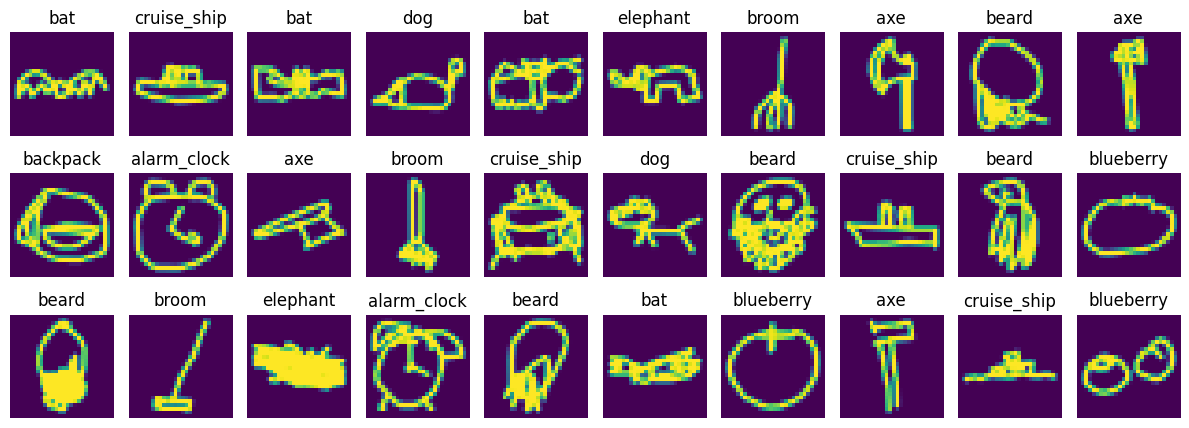

In [6]:
show_images(bmap, 30)

It'll also be interesting seeing images from each category overlayed on top of eachother as a heatmap, this will give a general understanding of the way people interpret cetain objects as some may interpret some objects to have multiple meanings.
* Ex: bat -> baseball bat, animal bat, cricket bat, etc.


Or some may also draw the same objects differently
* Ex: Orientations, style

To achieve this, I'll stack each image on top of each other then squeeze back into 2D

In [7]:
def category_heatmap(df):
    '''
    Overlaying bitmaps of different category to create a heatmap
    
    parameters: 
    df: dataframe with X and y columns
    
    output: categorical heatmaps
    returns: none
    '''
    
    categories = df['y'].unique()
    n_cat = len(categories)
    
    fig_h = 1.5 * (n_cat//5)
    fig, axs = plt.subplots(n_cat//5, 5, figsize=(7, fig_h))
    axs = axs.flatten()
    
    for n in range(n_cat):
        arrs = df[df['y'] == categories[n]]['X']
        heatmap = np.stack(arrs).sum(axis=0)
      
        axs[n].imshow(heatmap)
        axs[n].set_title(categories[n])
        axs[n].axis('off')
        
    plt.tight_layout()
    plt.show()

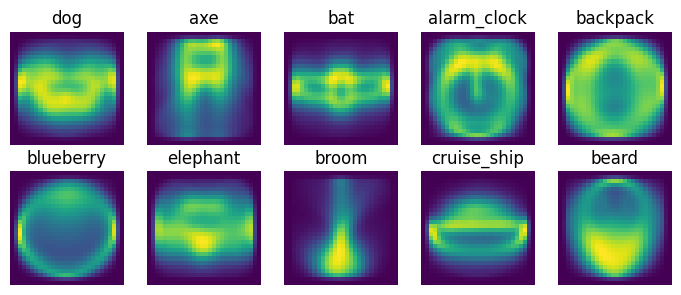

In [8]:
category_heatmap(bmap)

A few examples of things that we can infer about the people who partook in making the drawings.
* Bat is mostly interpreted as the animal
* Broom is mostly drawn as being upright
* Alarm clock is mostly interpreted as an analog one

### Aurgmenting dataset
Add sensible variation by "generating" more images based on the images already present
* Rotating: +-15 deg [scipy.ndimage rotate]
* Flipping: horizontal and vertical

*Ill first  train the model without the extra argmented data, then with it to assess if it makes a difference*

This improves **generalization** while reducing **overfitting** and **variation**.

Depending on the representation of each category i might decide to further aurgment specific categories

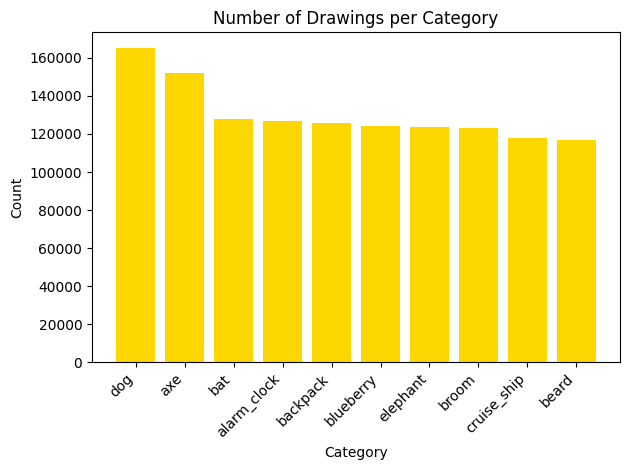

In [9]:
plt.bar(bmap['y'].unique(), bmap['y'].value_counts(), color='gold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Number of Drawings per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

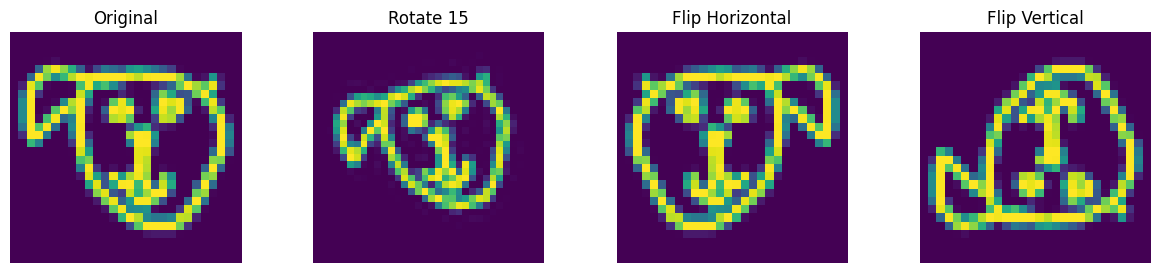

In [10]:
# emaple
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
[ax.axis('off') for ax in axs]
image = bmap.iloc[0, 1]

axs[0].imshow(image)
axs[0].set_title('Original')

axs[1].imshow(rotate(image, 15))
axs[1].set_title('Rotate 15')

axs[2].imshow(image[:,::-1])
axs[2].set_title('Flip Horizontal')

axs[3].imshow(image[::-1,:])
axs[3].set_title('Flip Vertical')

plt.show()

In [12]:
# bmap_hflip = bmap.copy()
# bmap_hflip['X'] = bmap_hflip['X'].apply(lambda x: x[:, ::-1])
# bmap_15rot = bmap.copy()
# bmap_15rot['X'] = bmap_15rot['X'].apply(lambda x: rotate(x, 15))

# bmap_xl = pd.concat([bmap, bmap_hflip, bmap_15rot], axis=0).reset_index(drop=True)

I'll begin with implementing a simple CNN with the following layers:
* Input: (1,28,28) (784) 28x28 monochrome image
* Conv(16, 5x5) -> Batch Norm -> ReLU -> Pool(2x2)
* Conv(32, 5x5) -> Batch Norm -> ReLU -> Pool(2x2)
* Flatten: 512 neurons
* Dense(128) -> ReLU -> Dropout()
* Dense(10)

## Convolutional Neural Network Implementation

The objective is to create a deep learning neural network which:
* **Input**:28x28 image input 
* **Return** probability of the drawing being each class

I'll begin with implementing a simple CNN with the following layers:

- **Input**: 28x28 grayscale image.
- **Conv**: 16 filters (out channels), 5x5 kernel, ReLU activation → Output: 28x28x16. (1 pad)
- **MaxPooling**: 2x2 pool → Output: 14x14x16.
- **Conv**: 32 filters, 5x5 kernel, ReLU activation → Output: 14x14x32.
- **MaxPooling**: 2x2 pool → Output: 8x8x32. *to be used as input for dense*
- **Flatten**: Convert to 1D → Output: 2048.
- **Dense**: 10 neurons, Softmax activation → Output: 10 (class probabilities).

### Preparing Data
Split into batches, for computational efficiency.
* `batch_size`: 64.
* `train`, `test`, `validation`: 80/10/10

In [82]:
torch.manual_seed(0)

train_df, test_df = train_test_split(bmap, test_size=0.2, random_state=0)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=0)

print(f'Train: {train_df.shape[0]}, Test: {test_df.shape[0]}, Validation: {val_df.shape[0]}')

Train: 1043184, Test: 130398, Validation: 130399


In [83]:
batch_size = 64

train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False)

In [88]:
# Convert DataFrame to tensors for PyTorch DataLoader
def df_to_tensors(df):
    X = torch.tensor(np.stack(df['X'].values)).float() / 255.0  # Normalize to [0, 1]
    X = X.unsqueeze(1)  # Add channel dimension (batch_size, 1, 28, 28)
    y = torch.tensor(pd.Categorical(df['y']).codes).long()  # Convert labels to integers
    return X, y

# Prepare data for DataLoader
train_X, train_y = df_to_tensors(train_df)
test_X, test_y = df_to_tensors(test_df)
val_X, val_y = df_to_tensors(val_df)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(list(zip(train_X, train_y)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(test_X, test_y)), batch_size=batch_size, shuffle=False)
val_loader = DataLoader(list(zip(val_X, val_y)), batch_size=batch_size, shuffle=False)

# Check the new DataLoader setup
print(f'Train loader batches: {len(train_loader)}')
print(f'Test loader batches: {len(test_loader)}')
print(f'Validation loader batches: {len(val_loader)}')


Train loader batches: 16300
Test loader batches: 2038
Validation loader batches: 2038


### Model Building
Convolutional Neural Network with the layers mantioned before. Ill split in into 2 sets:
* Conv1
* Fully Connected

In [89]:
class QuickDrawCNN_V1(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), n_classes=10):
        super().__init__()
        
        self.conv_set_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )   
        
        self.conv_set_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.flatten = nn.Flatten()
        
        # fully connected
        self.fc = nn.Sequential( 
            nn.Linear(32 * 5 * 5, n_classes),
            #nn.Softmax(dim=1) # CrossEntropyLoss() already has softmax
        )
        
        self.stack = nn.Sequential(
            self.conv_set_1,
            self.conv_set_2,
            self.flatten,
            self.fc
        )
        
    def forward(self, x):
        x = self.stack(x)
        return x

In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

model_1 = QuickDrawCNN_V1().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

Using cuda


In [91]:
def calc_accuracy(y_pred, y_true):
    y_pred = y_pred.argmax(dim=1)  # Fing the index of the max value
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [92]:
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, device):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    for epoch in range(epochs):
        
        epoch_train_loss, epoch_train_acc = 0, 0
        size = len(train_loader)
        
        # Train
        for image, label in train_loader:
            model.train()
            
            image, label = image.to(device), label.to(device) # move data to device
            
            y_logits = model(image) # forward pass
            
            # calculate loss, acc
            loss = loss_fn(y_logits, label)
            acc = calc_accuracy(y_logits, label)
            
            optimizer.zero_grad() # zero grad
            loss.backward() # backward pass, prep for backpass
            optimizer.step() # update weights
            
            epoch_train_loss += loss.item()
            epoch_train_acc += acc
        
        train_loss.append(epoch_train_loss / size)
        train_acc.append(epoch_train_acc / size)
        
        # Validation
        model.eval()
        epoch_train_loss, epoch_train_acc = 0, 0
        size = len(val_loader)
        
        with torch.inference_mode():
            for image, label in val_loader:
                image, label = image.to(device), label.to(device)
                y_logits = model(image)
                loss = loss_fn(y_logits, label)
                acc = calc_accuracy(y_logits, label)
                
                epoch_train_loss += loss.item()
                epoch_train_acc += acc
                
        val_loss.append(epoch_train_loss / size)
        val_acc.append(epoch_train_acc / size)
        
        print(f'Epoch: {epoch+1} | Val Loss {val_loss[-1]:.5f} | Val Acc {val_acc[-1]:.2f}%') # [-1] last element
        
    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train(
    model=model_1,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=5,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x800 and 2048x10)